In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
import optuna

# Modelos de machine learning
from lightgbm import LGBMClassifier
import lightgbm as lgb
from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

# Métricas y validación cruzada
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split

# Preprocesamiento de datos
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


## 1- LOADING DATA

In [82]:
ss = pd.read_csv("/kaggle/input/playground-series-s4e10/sample_submission.csv")
df_train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")

## 2- SHOWING DATA INFO & SHAPE

In [83]:
df_train.columns

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

In [84]:
df_train.shape

(58645, 13)

In [85]:
df_train.dtypes

id                              int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object

## 3- NULL VALUES

In [86]:
df_train.isna().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

## 4- VISUALIZATION

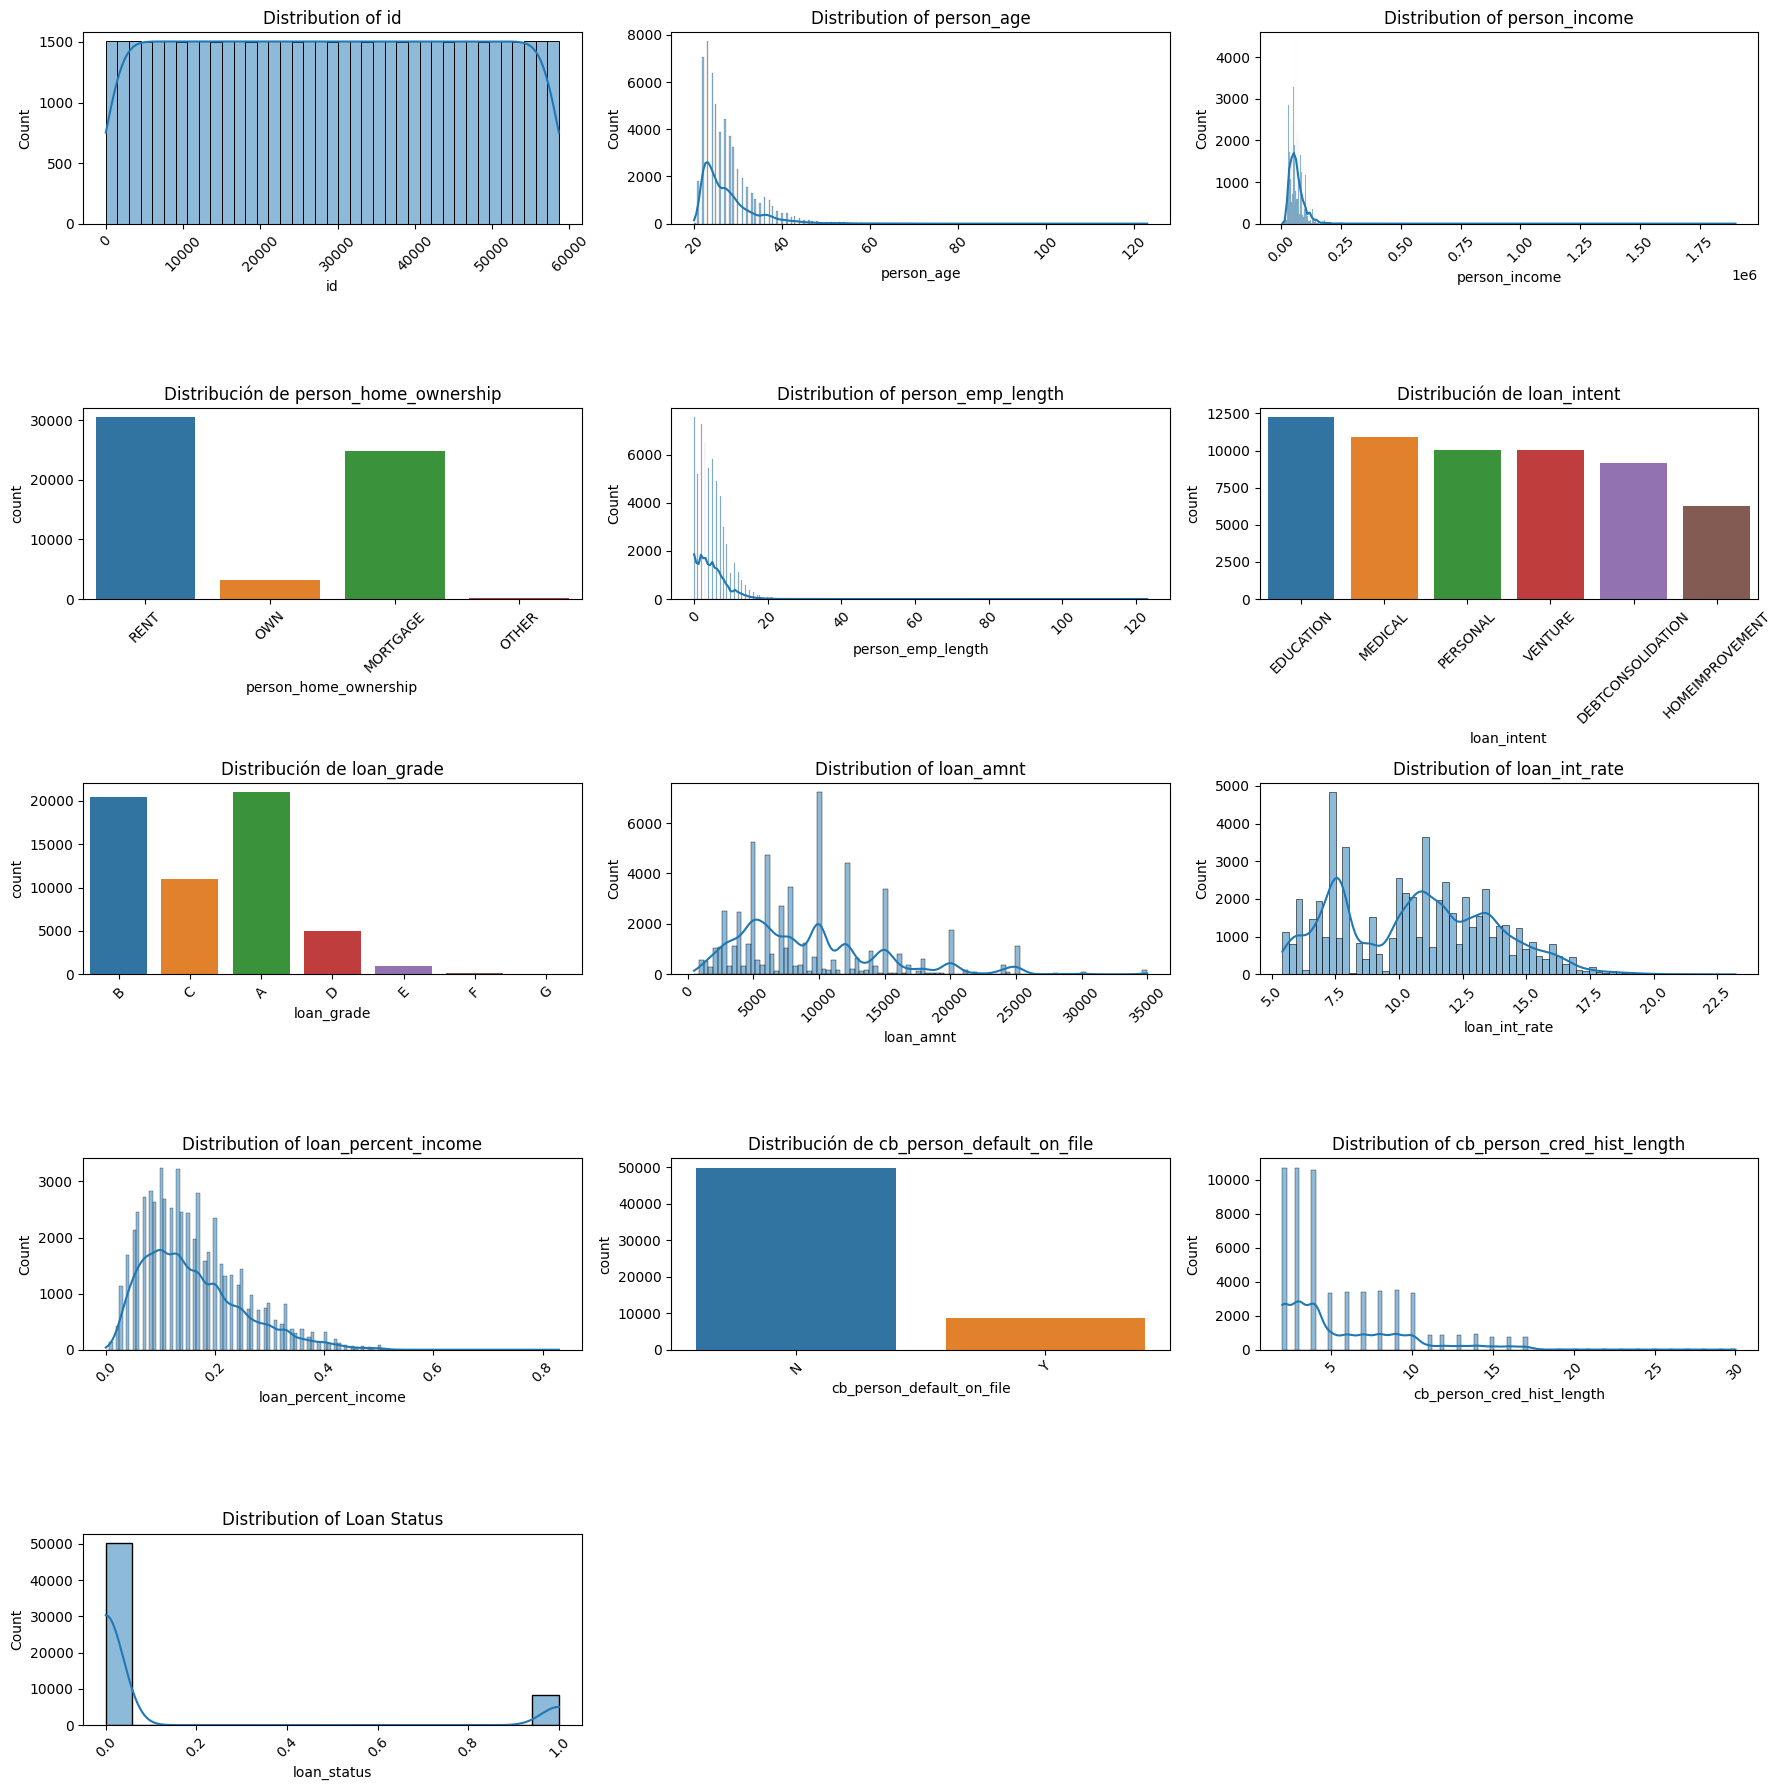

In [87]:
graficos_por_fila = 3


fig, axes = plt.subplots(nrows=np.ceil(len(df_train.columns)/graficos_por_fila).astype(int), 
                         ncols=graficos_por_fila, figsize=(18, 18))


axes = axes.flatten()


for i, column in enumerate(df_train.columns):

    if df_train[column].dtype in ['int64', 'float64']:
        if column != 'loan_status':  
            sns.histplot(df_train[column], kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution of {column}')
        else:
            sns.histplot(df_train['loan_status'], kde=True, ax=axes[i])
            axes[i].set_title('Distribution of Loan Status')
    

    elif df_train[column].dtype == 'object' or df_train[column].nunique() <= 10:
        sns.countplot(x=df_train[column], ax=axes[i])
        axes[i].set_title(f'Distribución de {column}')

    axes[i].tick_params(axis='x', rotation=45)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

## 5- PREPROCESSING

In [88]:
df_train = df_train.drop(columns=['id'])

#Binary columns
#le = LabelEncoder()
#df_train['cb_person_default_on_file'] = le.fit_transform(df_train['cb_person_default_on_file'])

#One-Hot Encoding for categorical columns
#df_train = pd.get_dummies(df_train, columns=['person_home_ownership', 'loan_intent', 'loan_grade'], drop_first=True)


## **6- FEATURE ENGINEERING**

In [89]:
def feature_engineering(df):
    # Copiar el DataFrame original para no modificarlo directamente
    df = df.copy()
    
    # 1. Transformaciones en Variables Numéricas
    if 'person_age' in df.columns:
        df['person_age_log'] = np.log1p(df['person_age'])  # Logaritmo natural + 1 para evitar log(0)
    if 'person_income' in df.columns:
        df['person_income_log'] = np.log1p(df['person_income'])
    if 'loan_amnt' in df.columns:
        df['loan_amnt_log'] = np.log1p(df['loan_amnt'])
    if 'loan_percent_income' in df.columns:
        df['loan_percent_income_sqrt'] = np.sqrt(df['loan_percent_income'])  # Raíz cuadrada
    
    # 2. Interacciones entre Variables Numéricas
    if {'person_age', 'loan_amnt'}.issubset(df.columns):
        df['age_loan_ratio'] = df['person_age'] / df['loan_amnt']  # Edad/Préstamo
    if {'person_income', 'loan_amnt'}.issubset(df.columns):
        df['income_loan_ratio'] = df['person_income'] / df['loan_amnt']  # Ingreso/Préstamo
    
    # 3. One-Hot Encoding para Variables Categóricas
    categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    # 4. Columnas de Frecuencia para Variables Categóricas
    for col in categorical_cols:
        if col in df.columns:
            freq_encoding = df[col].value_counts(normalize=True)
            df[f'{col}_freq'] = df[col].map(freq_encoding)
    
    # 5. Normalización de Variables Continuas (Opcional)
    if 'person_emp_length' in df.columns:
        df['emp_length_normalized'] = (df['person_emp_length'] - df['person_emp_length'].mean()) / df['person_emp_length'].std()
    if 'cb_person_cred_hist_length' in df.columns:
        df['cred_hist_length_normalized'] = (df['cb_person_cred_hist_length'] - df['cb_person_cred_hist_length'].mean()) / df['cb_person_cred_hist_length'].std()

    return df



In [90]:
df_train_transformed = feature_engineering(df_train)

In [91]:
X = df_train_transformed.drop(columns=['loan_status']) 
y = df_train_transformed['loan_status'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 7- STACKING

In [92]:
pip install optuna


Note: you may need to restart the kernel to use updated packages.


In [93]:

# # Definir la función objetivo para Optuna
# def objective(trial, model_name):
#     # Configurar los hiperparámetros según el modelo
#     if model_name == 'xgb':
#         params = {
#             'n_estimators': trial.suggest_int('xgb_n_estimators', 50, 300),
#             'max_depth': trial.suggest_int('xgb_max_depth', 3, 10),
#             'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 1e-4, 1.0),
#             'colsample_bytree': trial.suggest_uniform('xgb_colsample_bytree', 0.5, 1.0),
#             'subsample': trial.suggest_uniform('xgb_subsample', 0.5, 1.0)
#         }
#         model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', verbosity=0)  # Silenciar XGBoost
    
#     elif model_name == 'lgbm':
#         params = {
#             'n_estimators': trial.suggest_int('lgbm_n_estimators', 50, 300),
#             'max_depth': trial.suggest_int('lgbm_max_depth', 3, 10),
#             'learning_rate': trial.suggest_loguniform('lgbm_learning_rate', 1e-4, 1.0),
#             'num_leaves': trial.suggest_int('lgbm_num_leaves', 20, 150),
#             'feature_fraction': trial.suggest_uniform('lgbm_feature_fraction', 0.5, 1.0),
#             'bagging_fraction': trial.suggest_uniform('lgbm_bagging_fraction', 0.5, 1.0),
#             'bagging_freq': trial.suggest_int('lgbm_bagging_freq', 1, 10)
#         }
#         model = LGBMClassifier(**params, verbose=-1)  # Silenciar LightGBM
    
#     elif model_name == 'catboost':
#         params = {
#             'iterations': trial.suggest_int('catboost_iterations', 50, 300),
#             'depth': trial.suggest_int('catboost_depth', 3, 10),
#             'learning_rate': trial.suggest_loguniform('catboost_learning_rate', 1e-4, 1.0),
#             'l2_leaf_reg': trial.suggest_loguniform('catboost_l2_leaf_reg', 1e-4, 10),
#             'border_count': trial.suggest_int('catboost_border_count', 32, 255)
#         }
#         model = CatBoostClassifier(**params, silent=True)  # Silenciar CatBoost
    
#     # Inicializar Stratified K-Fold
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     roc_auc_scores = []

#     # Validación cruzada estratificada
#     for train_index, valid_index in skf.split(X_train, y_train):
#         X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
#         y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]
        
#         # Entrenar el modelo en el fold de entrenamiento
#         model.fit(X_train_fold, y_train_fold)
        
#         # Predecir probabilidades en el fold de validación
#         y_pred_proba = model.predict_proba(X_valid_fold)[:, 1]
        
#         # Calcular el ROC-AUC para el fold
#         roc_auc = roc_auc_score(y_valid_fold, y_pred_proba)
#         roc_auc_scores.append(roc_auc)

#     # Devolver la media del ROC-AUC de los 5 folds
#     return np.mean(roc_auc_scores)

# # Configurar Optuna para reducir verbosidad
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# # Optimizar los hiperparámetros de cada modelo
# best_params = {}

# for model_name in ['xgb', 'lgbm', 'catboost']:
#     print(f"Optimizando hiperparámetros para {model_name}")
#     study = optuna.create_study(direction='maximize')
#     study.optimize(lambda trial: objective(trial, model_name), n_trials=50)
    
#     # Guardar los mejores hiperparámetros para el modelo
#     best_params[model_name] = study.best_params
#     print(f"Mejores hiperparámetros para {model_name}: {study.best_params}")

# # Imprimir todos los mejores parámetros
# print("Todos los mejores hiperparámetros:", best_params)


Optimizando hiperparámetros para xgb
Mejores hiperparámetros para xgb: {'xgb_n_estimators': 278, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.10284556509754939, 'xgb_colsample_bytree': 0.8479454303135073, 'xgb_subsample': 0.9586008060448009}
Optimizando hiperparámetros para lgbm
Mejores hiperparámetros para lgbm: {'lgbm_n_estimators': 297, 'lgbm_max_depth': 9, 'lgbm_learning_rate': 0.08925766682867645, 'lgbm_num_leaves': 22, 'lgbm_feature_fraction': 0.8638163274694255, 'lgbm_bagging_fraction': 0.9307176638719188, 'lgbm_bagging_freq': 9}
Optimizando hiperparámetros para catboost

Training has stopped (degenerate solution on iteration 25, probably too small l2-regularization, try to increase it)

Mejores hiperparámetros para catboost: {'catboost_iterations': 187, 'catboost_depth': 3, 'catboost_learning_rate': 0.5644432724011859, 'catboost_l2_leaf_reg': 0.005218312124167164, 'catboost_border_count': 150}
Todos los mejores hiperparámetros: {'xgb': {'xgb_n_estimators': 278, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.10284556509754939, 'xgb_colsample_bytree': 0.8479454303135073, 'xgb_subsample': 0.9586008060448009}, 'lgbm': {'lgbm_n_estimators': 297, 'lgbm_max_depth': 9, 'lgbm_learning_rate': 0.08925766682867645, 'lgbm_num_leaves': 22, 'lgbm_feature_fraction': 0.8638163274694255, 'lgbm_bagging_fraction': 0.9307176638719188, 'lgbm_bagging_freq': 9}, 'catboost': {'catboost_iterations': 187, 'catboost_depth': 3, 'catboost_learning_rate': 0.5644432724011859, 'catboost_l2_leaf_reg': 0.005218312124167164, 'catboost_border_count': 150}}


In [94]:

# Definir los modelos base con los mejores hiperparámetros
xgb_params = {'n_estimators': 278, 'max_depth': 5, 'learning_rate': 0.10284556509754939,
              'colsample_bytree': 0.8479454303135073, 'subsample': 0.9586008060448009, 'use_label_encoder': False, 'eval_metric': 'logloss', 'verbosity': 0}
lgbm_params = {'n_estimators': 297, 'max_depth': 9, 'learning_rate': 0.08925766682867645,
               'num_leaves': 22, 'feature_fraction': 0.8638163274694255, 'bagging_fraction': 0.9307176638719188, 'bagging_freq': 9, 'verbose': -1}
cat_params = {'iterations': 187, 'depth': 3, 'learning_rate': 0.5644432724011859,
              'l2_leaf_reg': 0.005218312124167164, 'border_count': 150, 'silent': True}

# Crear los modelos base
xgb_model = XGBClassifier(**xgb_params)
lgbm_model = LGBMClassifier(**lgbm_params)
cat_model = CatBoostClassifier(**cat_params)

# Inicializar Stratified K-Fold para entrenamiento de modelos base
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Arrays para almacenar las predicciones de los modelos base
oof_xgb = np.zeros(len(X_train))
oof_lgbm = np.zeros(len(X_train))
oof_cat = np.zeros(len(X_train))

# Entrenar modelos base usando validación cruzada y almacenar las predicciones
for train_index, valid_index in skf.split(X_train, y_train):
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    # XGBoost
    xgb_model.fit(X_train_fold, y_train_fold)
    oof_xgb[valid_index] = xgb_model.predict_proba(X_valid_fold)[:, 1]
    
    # LightGBM
    lgbm_model.fit(X_train_fold, y_train_fold)
    oof_lgbm[valid_index] = lgbm_model.predict_proba(X_valid_fold)[:, 1]
    
    # CatBoost
    cat_model.fit(X_train_fold, y_train_fold)
    oof_cat[valid_index] = cat_model.predict_proba(X_valid_fold)[:, 1]

# Crear un DataFrame con las predicciones de los modelos base como características para el meta-modelo
stacked_train = np.column_stack((oof_xgb, oof_lgbm, oof_cat))

# Entrenar el modelo final (meta-modelo)
meta_model = LogisticRegression()
meta_model.fit(stacked_train, y_train)

# Obtener predicciones de los modelos base en el conjunto de prueba
xgb_test_pred = xgb_model.predict_proba(X_test)[:, 1]
lgbm_test_pred = lgbm_model.predict_proba(X_test)[:, 1]
cat_test_pred = cat_model.predict_proba(X_test)[:, 1]

# Crear un DataFrame con las predicciones de los modelos base en el conjunto de prueba
stacked_test = np.column_stack((xgb_test_pred, lgbm_test_pred, cat_test_pred))

# Obtener predicciones finales del meta-modelo en el conjunto de prueba
final_predictions = meta_model.predict_proba(stacked_test)[:, 1]

# Evaluación final (por ejemplo, ROC-AUC en el conjunto de prueba)
roc_auc = roc_auc_score(y_test, final_predictions)
print("ROC-AUC del modelo final de stacking:", roc_auc)


ROC-AUC del modelo final de stacking: 0.9570197865657695


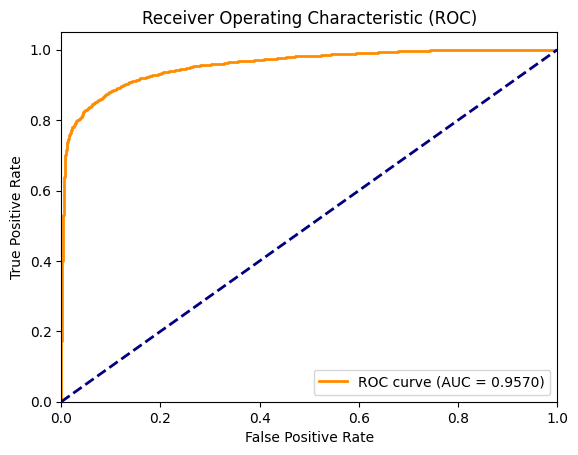

In [95]:
fpr, tpr, thresholds = roc_curve(y_test, final_predictions)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Matriz de Confusión:
[[9939  148]
 [ 417 1225]]


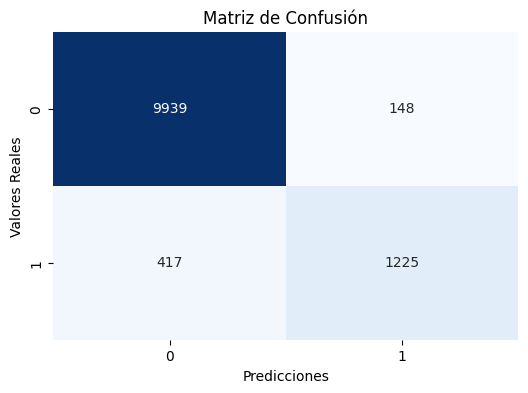

In [96]:
y_pred = (final_predictions >= 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)



plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

#### **FEATURE IMPORTANCE**

<Figure size 1000x800 with 0 Axes>

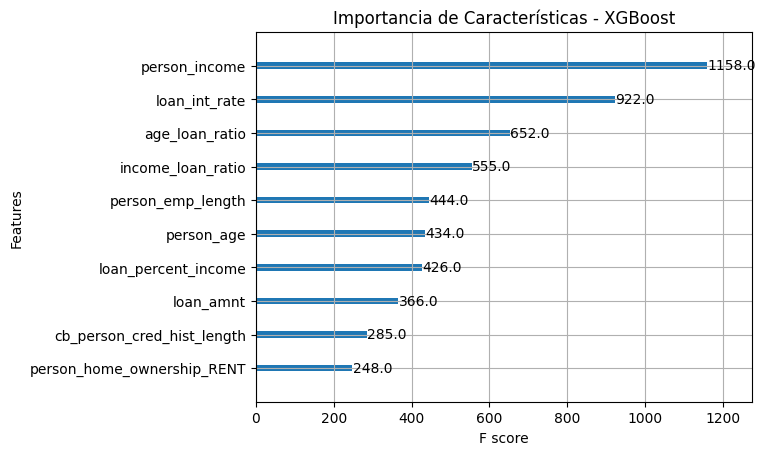

In [97]:

# Ajustar el modelo final para obtener la importancia de características
xgb_model.fit(X_train, y_train)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=10)  # max_num_features muestra solo las 10 más importantes
plt.title("Importancia de Características - XGBoost")
plt.show()


<Figure size 1000x800 with 0 Axes>

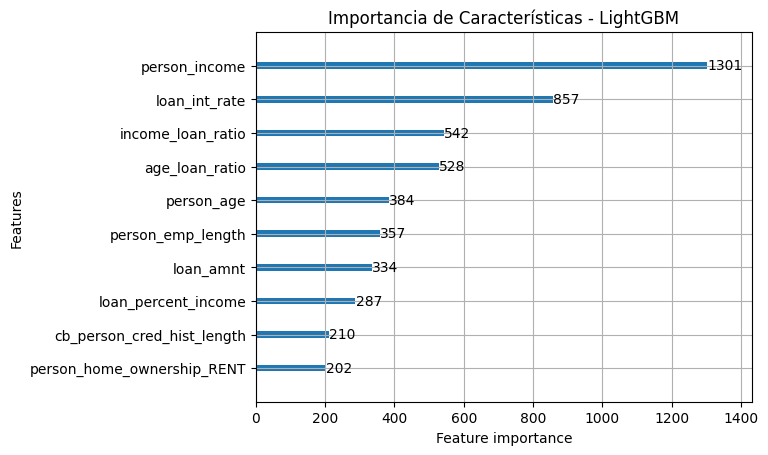

In [98]:

# Ajustar el modelo final para obtener la importancia de características
lgbm_model.fit(X_train, y_train)

# Visualizar la importancia de las características usando lightgbm.plot_importance
plt.figure(figsize=(10, 8))
lgb.plot_importance(lgbm_model, max_num_features=10)  # max_num_features muestra solo las 10 más importantes
plt.title("Importancia de Características - LightGBM")
plt.show()


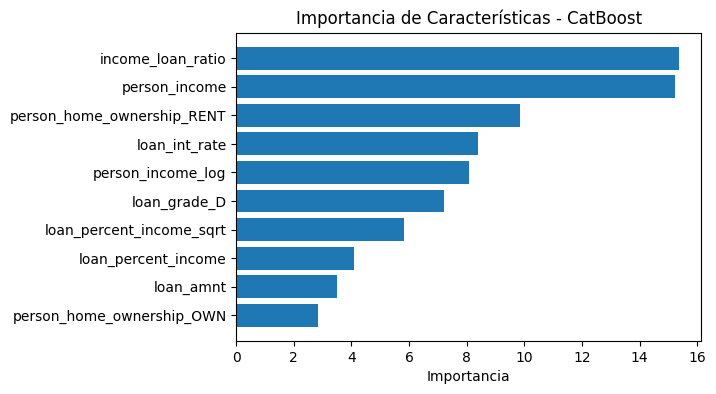

In [99]:

# Ajustar el modelo final para obtener la importancia de características
cat_model.fit(X_train, y_train)

# Obtener la importancia de las características
feature_importances = cat_model.get_feature_importance()
feature_names = X_train.columns

# Crear un DataFrame con los nombres y la importancia de las características
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Ordenar por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualizar la importancia de las características
plt.figure(figsize=(6, 4))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])  # Mostrar solo las 10 más importantes
plt.xlabel("Importancia")
plt.title("Importancia de Características - CatBoost")
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar la


####  **FEATURE IMPORTANCE OF BASE MODELS' PROBABILITIES**

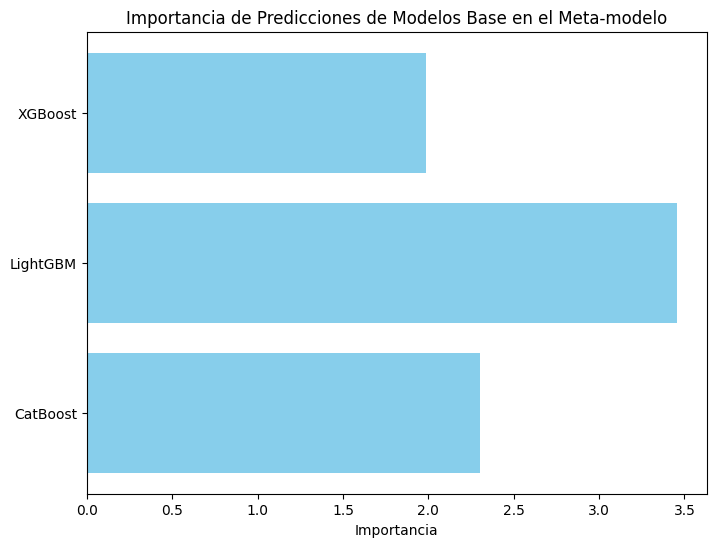

In [100]:

# Los nombres de las "características" (predicciones de los modelos base)
model_names = ['XGBoost', 'LightGBM', 'CatBoost']

# Obtener los coeficientes del meta-modelo (LogisticRegression)
meta_model_coefficients = meta_model.coef_.flatten()  # Convertimos los coeficientes en una lista plana si es necesario

# Crear un DataFrame para visualizar las importancias
importance_df = pd.DataFrame({'Model': model_names, 'Importance': meta_model_coefficients})

# Graficar la importancia de las características
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Model'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importancia")
plt.title("Importancia de Predicciones de Modelos Base en el Meta-modelo")
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar el más importante en la parte superior
plt.show()


## 8 - FINAL PREDICTION

In [101]:
# Aplicar la función de feature engineering a df_test para que tenga las mismas columnas que df_train
df_test_transformed = feature_engineering(df_test)

# Eliminar la columna de ID
X_test_final = df_test_transformed.drop(columns=['id'])

# Generar predicciones de probabilidad de los modelos base en X_test_final
xgb_test_pred = xgb_model.predict_proba(X_test_final)[:, 1]
lgbm_test_pred = lgbm_model.predict_proba(X_test_final)[:, 1]
cat_test_pred = cat_model.predict_proba(X_test_final)[:, 1]

# Crear un DataFrame con las predicciones de los modelos base para el meta-modelo
stacked_test_final = np.column_stack((xgb_test_pred, lgbm_test_pred, cat_test_pred))

# Obtener predicciones finales del meta-modelo
final_predictions = meta_model.predict_proba(stacked_test_final)[:, 1]

# Crear el DataFrame de envío
submission = pd.DataFrame({
    'id': df_test['id'],
    'loan_status': final_predictions
})

# Guardar el archivo de envío
submission.to_csv("submission.csv", index=False)

# Mostrar las primeras filas del archivo de envío
print(submission.head())


      id  loan_status
0  58645     0.982010
1  58646     0.027811
2  58647     0.741928
3  58648     0.025732
4  58649     0.036173
